<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/3.3.2/es5/tex-mml-chtml.js"></script>

# Vertically Integrated Moisture Flux Convergence

This script illustrates calculating vertically integrated moisture flux convergence (MFC) for a dataset with a constant pressure level system.

To calculate this, we must first leverage [`geocat.comp.meteorology.delta_pressure`](https://geocat-comp.readthedocs.io/en/latest/user_api/generated/geocat.comp.meteorology.delta_pressure.html) for the vertical integration, and then [`geocat.comp.gradient.gradient`](https://geocat-comp.readthedocs.io/en/latest/user_api/generated/geocat.comp.gradient.gradient.html#geocat.comp.gradient.gradient) to get our gradients on the surface of the WGS84 ellipsoid.

In [1]:
import xarray as xr
import numpy as np
import geocat.comp as gc
import geocat.datafiles as gcd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load Data

Here we load in a dummy Xarray Dataset with 2d zonal and meridional wind componenets (`u_wind` and `v_wind`), 3d water vapor (`q_vapor`), a 2d surface pressure array (`surface_pressure`), and a 1d pressure level system (`pressure_lev`).

In [2]:
ds = xr.open_dataset(gcd.get("netcdf_files/dummy_uvqp_data.nc"))
ds

<xarray.Dataset>
Dimensions:           (x: 20, y: 40, lev: 13)
Coordinates:
    lon               (x, y) float64 ...
    lat               (x, y) float64 ...
    pressure_lev      (lev) int64 ...
Dimensions without coordinates: x, y, lev
Data variables:
    u_wind            (x, y) float64 ...
    v_wind            (x, y) float64 ...
    q_vapor           (x, y, lev) float64 ...
    surface_pressure  (x, y) float64 ...

#  Vertical Integration

To do a mass-weighted vertical integration of our 3d water vapor, we need to first get a layer mass weighting. This is our delta pressure levels, divide by the gravitational constant. Then, multiply the layer mass weighting by the water vapor variable, and integrate vertially. 

In [3]:
delta_pressure_levels = gc.meteorology.delta_pressure(pressure_lev=ds.pressure_lev, surface_pressure=ds.surface_pressure)

g = 9.80665 # gravitational acceleration (m s-2)
layer_mass_weighting = delta_pressure_levels / g # Layer Mass Weighting
layer_mass_weighting .attrs["units"] = "kg m-2"

mass_weighted_vapor = ds.q_vapor * layer_mass_weighting # mass weighted 'q'
iq = mass_weighted_vapor.sum(dim="lev") # Vertically Integrated Vapor
iq.attrs["units"] = "g m-2"

# Calculate Moisture Flux Convergence (MFC)

The formula for MFC is as follows:

$$MFC = -u\frac{dq}{dx} - v\frac{dq}{dy} - q\left(\frac{du}{dx} + \frac{dv}{dy}\right)$$


where u represents the zonal wind component, v is the meridional wind componenet, and q is the moisture content (in our case, vertically integrated).

Sure! Here's how you can fix the equations in the line of text:

The first two terms of this equation, $$-u*\frac{dq}{dx} - v*\frac{dq}{dy}$$, are together the advection term, and the last term, $$q(\frac{du}{dx} + \frac{dv}{dy})$$, is our convergence term, with moisture flux convergence being the advection minus the convergence.

[Source: Banacos and Schultz, "Moisture Flux Convergence", NOAA 2004](https://www.spc.noaa.gov/publications/banacos/mfc-sls.pdf)

To do this calculation, we first need the gradients of our wind components and moisture. We are using Geocat-comp's [`gradient`](https://geocat-comp.readthedocs.io/en/latest/user_api/generated/geocat.comp.gradient.gradient.html#geocat.comp.gradient.gradient) method because of its improved accuracy for geospatial data over an Earth-like ellipsoid.

In [4]:
du_dx, du_dy = gc.gradient(ds.u_wind) # (s-1)
dv_dx, dv_dy = gc.gradient(ds.v_wind)
dq_dx, dq_dy = gc.gradient(iq) # (g m-3)

In [5]:
advection = (-ds.u_wind * dq_dx) - (ds.v_wind * dq_dy) # (g s-1 m-2)
convergence = iq * np.add(du_dx, dv_dy) # (g s-1 m-2)

mfc = advection - convergence # moisture flux convergence (g m-2 s-1)
mfc

<xarray.DataArray (x: 20, y: 40)>
array([[ 1.22064703e-01, -3.12128939e-01, -5.96595436e-02,
        -2.25516841e-01, -2.70725319e-01, -1.20396395e-01,
         7.55133505e-02, -2.09545354e-01,  8.72083656e-02,
         2.61595018e-01, -2.06763083e-01,  7.83812372e-02,
         2.05628902e-02,  1.43312631e-01, -2.37694081e-01,
         4.22776599e-01, -5.96577422e-02, -4.16869163e-01,
        -1.14914013e-02,  1.00259343e-01,  1.61890966e-01,
        -2.60197367e-01,  8.82344837e-02,  3.03994766e-01,
        -1.40376617e-01,  1.20312225e-01, -5.02249982e-02,
        -7.68566796e-02, -5.46356546e-02,  7.02835463e-02,
         4.93524082e-02, -9.00835117e-02, -5.58480753e-02,
         8.14280214e-02,  3.55652926e-02,  1.42111460e-01,
        -1.01098113e-02,  1.81838364e-02, -5.45783703e-01,
         5.91513590e-02],
       [-3.12641494e-02,  1.06947688e-01,  1.34283405e-01,
        -3.37847424e-02,  1.08115689e-02,  2.52913528e-02,
        -4.24634114e-02,  1.14821632e-02, -1.25382538e-02,
        -4.01496953e-02, -1.60356749e-02,  3.74027805e-02,
        -1.98496909e-01, -7.18312195e-03,  3.60838236e-02,
         1.96114748e-02, -1.36222200e-02,  6.11933885e-02,
...
        -6.05720215e-02, -1.36193152e-02, -6.09674563e-02,
        -3.29536498e-02,  5.78628885e-02, -6.48545969e-02,
        -7.21760370e-04, -4.87134738e-02, -1.86083236e-02,
         5.85945369e-02,  1.13874248e-02, -1.43162411e-01,
        -2.02898566e-04,  2.79319413e-02, -1.66124378e-02,
         5.51563881e-03],
       [ 5.55114858e-02,  1.68997453e-01,  1.66522592e-02,
         8.01187703e-01, -3.32522823e-02,  1.91175311e-02,
        -7.35270175e-02, -1.13793947e-02,  5.80357475e-02,
        -2.23158586e-02,  3.34206763e-02, -1.39950975e-02,
         1.29816405e-01, -2.35926059e-02,  1.44941552e-01,
        -4.50552110e-02, -1.06261601e-02,  1.61398009e-01,
        -2.80416590e-02, -2.91196876e-02,  1.15526957e-02,
         1.93081846e-02,  1.20017887e-01, -1.00753797e-01,
         1.20826703e-02,  3.44358041e-01, -7.73621468e-02,
        -4.84163671e-02, -4.34982935e-01,  1.04188116e-01,
         1.88039124e-02,  3.11744643e-02,  1.12264981e-02,
        -9.14767360e-02, -2.43382261e-01,  3.13623859e-01,
        -1.19396210e-01,  5.60148017e-04, -9.61885753e-03,
         1.24913746e-01]])
Coordinates:
    lon      (x, y) float64 60.0 61.03 62.05 63.08 ... 96.92 97.95 98.97 100.0
    lat      (x, y) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 25.0 25.0 25.0 25.0 25.0
Dimensions without coordinates: x, y

## Plot Data

And finally we can view our moisture flux convergence.

/Users/jkent/miniconda3/envs/gc-docs/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


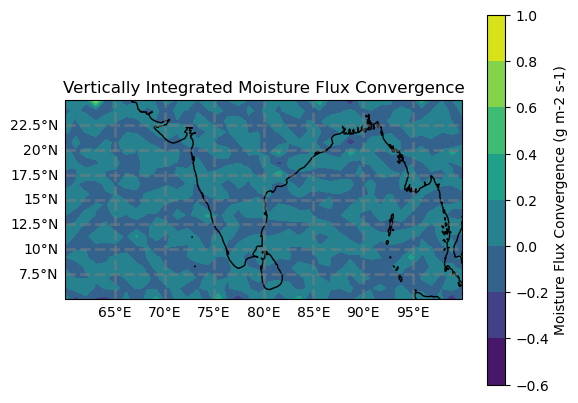

In [6]:
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(ds.lon, ds.lat, mfc, transform=ccrs.PlateCarree())
plt.title('Vertically Integrated Moisture Flux Convergence')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

cbar = plt.colorbar()
cbar.set_label('Moisture Flux Convergence (g m-2 s-1)')

ax.coastlines()


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False;